# Fundamental Diagram

## Purpose & Motivation
As with any academic exercise, it is often helpful to review the research done by others in the topic.  In particular, we are interested in research related to models describing traffic that could potentially be used for prediction.

## Direction from Advisor
Review the literature related to modeling/analyzing traffic.

## Tasks/Questions to Answer

### Questions to Answer
* Given a dataset consisting of Flow, Occupancy, and Speed, what models are available to describe the data?
* Does the model fit the data?

### Tasks
* Explore/describe the three-phase theory of traffic
* Explore/describe the fundamental diagram of traffic
* Use the fundamental diagram to display sample portions of the traffic data set

## Three-Phase Traffic


### Traffic Phases
Three-phase traffic theory was introduced by Bob Kerner in the late 90's.  It describes three phases of traffic (free-flow, synchronized flow, and wide-moving jam), which can be captured using velocity, flow, and density of vehicles.

#### Free-Flow
Traffic is freely moving at or near the maximum speed.  Individual vehicles may be traveling faster or slower.  
A positive correlation between the flow rate (in vehicles per unit time) and vehicle density (in vehicles per unit distance).  An increase in the vehicle density is also accompanied by an increase in die flow rate, and vice versa.  

#### Synchronized Flow
Traffic is moving at some variable fraction of the maximum speed.  All vehicles are traveling near the same speed.  
Flow rate and vehicle speed may vary significantly in the synchronized flow. An increase in the vehicle density can be accompanied by either an increase or by a decrease in the flow rate.  
Downstream front of synchronized flow is often spatially fixed (bottleneck).  

#### Jam
Traffic moves at a very small fraction of average free-flow speed, typically stop-and-go.  
Average vehicle speed within jams is much lower than the average speed in free flow.
Downstream front vehicles accelerate to the free flow speed, this front propogates upstream with a velocity described by the slope of the line J.  
Always has the same mean velocity of the downstream front.  
Flow rate is sharply reduced.  



#### Phase Characteristics

<table>
    <tr>
        <th></th>
        <th>Speed</th>
        <th>Flow</th>
        <th>Density</th>
    </tr>
    <tr>
        <th>Free flow</th>
        <td bgcolor='lightgreen'>High</td>
        <td bgcolor='lightgreen'>High</td>
        <td bgcolor='lightgreen'>Low</td>
    </tr>
        <tr>
        <th>Synchronized flow</th>
        <td bgcolor='lightyellow'>Middle to low</td>
        <td bgcolor='lightgreen'>Close to free flow</td>
        <td bgcolor='lightyellow'>Middle</td>
    </tr>
    <tr>
        <th>Jam</th>
        <td bgcolor='LIGHTCORAL'>Very low</td>
        <td bgcolor='LIGHTCORAL'>Very low</td>
        <td bgcolor='LIGHTCORAL'>Highest</td>
    </tr>
</table>

### Fundamental Diagram of Traffic
The fundamental diagram of traffic captures the characteristic elements of traffic necessary to identify traffic phases, given by the following relation:

$q = \rho v \text{, where } q \text{ is flow } (\frac{\text{number of vehicles}}{time}),$
$ \rho \text{ is density } (\frac{\text{number of vehicles}}{distance}), \text{and}$
$ v \text{ is speed } (\frac{\text{distance}}{time})$   

<img style='width: 40%; height: auto;', src='./fundamental_diagram.png'/>
<p style='text-align: center;'>Fig 1. Fundamental Diagram</p>

| Variable | Description | 
|--------------|-----------------------------------|
| $\rho_{min}$ | $\text{minimum density of a jam}$ |
| $\rho_{max}$ | $\text{maximum density of a jam}$  |
| $\rho_{max}^{(free)}$ | $\text{maximum density of free-flow}$ |
| $q_{max}^{(syn)}$ | $\text{maximum flow of synchronized traffic}$ | 
| $q_{max}^{(free)}$ | $\text{maximum flow of free-flow traffic}$ | 
| $q_{out}$ | $\text{outflow from a traffic jam}$  |


### The line J is given by the following:  

$q(\rho) = \frac{1}{\tau_{delay}}(1 - \frac{\rho}{\rho_{max}} ), \text{where}$

$\tau_{delay} = \text{time delay before a driver accelerates from a stop (estimated between 1.5 and 2 seconds)}$

The intersection of the line J and the line F, $(\rho_{min}, q_{out})$, marks the minimum density at which a jam can form $(\rho_{min})$ and the out-flow rate of vehicles leaving the jam $(q_{out})$.

$q_{out} = \frac{1}{\tau_{delay}}(1 - \frac{\rho_{min}}{\rho_{max}^{jam}} )$

$\rho_{min} = \frac{\frac{1}{\tau_{delay}}}{\frac{1}{\tau_{delay}*\rho_{max}}+\frac{q_{max}^{free}}{\rho_{max}^{free}}}$

(Jams cannot form at densities below $\rho_{min}$.  At densities above, free flow is metastable.)



#### The Line F
The line F describes a boundary above which traffic is in free-flow and below which it is in synchronized flow or a jam.  
The slope of the line F is the minimum speed at which traffic is in free-flow.

$q(\rho) = \frac{q_{max}^{free}}{\rho_{max}^{free}} \rho, \text{ where } \frac{q_{max}^{free}}{\rho_{max}^{free}} = v_{min}^{(free)} (\text{i.e. } \frac{\text{max flow}_{\text{free-flow}}}{\text{max density}_{\text{free-flow}}})$

### References

[1] _Three phase traffic theory_,  M. Park, 2012  
[2] _Experimental Features of Self-Organization in Traffic Flow_,  B. Kerner, 1998  
[3] _The physics of traffic_,  B. Kerner, 1999  
[4] _Complexity of Synchronized Flow and Related Problems for Basic Assumptions of Traffic Flow Theories_,  B. Kerner, 2001  
[5] _A microscopic model for phase transitions in traffic flow_,  B. Kerner and S. Klenov, 2002  
[6] _Failure of classical traffic flow theories: Stochastic highway capacity and automatic driving_, B. Kerner, 2015  
[7] _Three-Phase Traffic Theory and Highway Capacity_, B. Kerner, 2003  

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import gzip
import datetime as dt
from os import listdir
from os.path import isfile, join
import time
import itertools

from operator import itemgetter 

import matplotlib.pyplot as plt

import bokeh.io as bkio
import bokeh.plotting as bkplot
import bokeh.models as bkmod
import bokeh.layouts as bklay

from sklearn.cross_validation import train_test_split

import seaborn as sns
sns.set(color_codes=True)

import sys
sys.path.append('../')

import trafficpassion.timer as timer

In [3]:
bkplot.output_notebook()

Loading BokehJS ...

In [3]:
data_path = '../../../data/'
data_file = data_path + 'I5S_ML_data.csv'  #'I5S_data2.csv'

meta_path = '../../../data/meta/2015/d11/'
meta_file = meta_path + 'd11_text_meta_2015_12_17.txt'

output_path = '../graphs/'

### Load data

In [4]:
#colnames = ['Idx', 'Date', 'Time', 'Station', 'District', 'Freeway #', 'Direction', 'Lane Type', 'Station Length',
#                     'Samples', '% Observed', 'TotalFlow', 'AvgOccupancy', 'AvgSpeed', 'Lat', 'Lon', 'Order']

t0 = time.time()

df = pd.read_csv( data_file )
#df = pd.read_csv( data_file, header=None, skiprows=1 )
#df.columns = colnames

#df.drop( ['District', 'Freeway #', 'Direction', 'Lane Type', 
#       'Station Length', 'Samples', '% Observed', 'Lat', 'Lon', 'Idx'], 
#        axis=1, inplace=True)

print timer.timestr( time.time()-t0 )

df.shape

1.29 min


(10773178, 56)

In [9]:
t0 = time.time()
meta_df = pd.read_csv( meta_file, delimiter='\t' ) \
    .rename( columns={'ID':'Station'}) \
    .set_index('Station')
print timer.timestr( time.time()-t0 )

meta_df.shape

0.08 sec


(1424, 17)

### <p style='color:blue'>Free flow vs synchronized</p>

##### <p style='color:blue'>Line F</p>

$V_{min}^{free} = \frac{q_{max}^{free}}{\rho_{max}^{free}} \implies \rho_{max}^{free} = \frac{q_{max}^{free}}{V_{min}^{free}}$ 

We can calculate the $ \rho_{max}^{free}$ by assuming the maximum flow value we find is $ q_{max}^{free}$ and by estimating the minimum average speed of free-flow  $ V_{min}^{free}$

$\text{velocity (ie. slope of F line) } = \frac{\text{ max flow }}{\text{ max density }} \implies \frac{q_{max}^{free}}{\rho_{max}^{free}}$


-----

##### <p style='color:blue'>Line J</p>

$ \text{Single lane: }  q(\rho) = \frac{1}{\tau_{delay}}(1 - \frac{\rho}{\rho_{max}^{jam}} ) \implies \text{Multiple lanes: }  q(\rho) = \frac{n_{lanes}}{\tau_{delay}}(1 - \frac{\rho}{\rho_{max}^{jam}} ) $

$\text{Single lane: }  \rho_{min} = \frac{\frac{1}{\tau_{delay}}}{\frac{1}{\tau_{delay}*\rho_{max}^{jam}}+\frac{q_{max}^{free}}{\rho_{max}^{free}}}  \implies  \text{Multiple lanes: }  \rho_{min} = \frac{\frac{n_{lanes}}{\tau_{delay}}}{\frac{n_{lanes}}{\tau_{delay}*\rho_{max}^{jam}}+\frac{q_{max}^{free}}{\rho_{max}^{free}}}$

$\text{Single lane: }  q_{out} = \frac{1}{\tau_{delay}}(1 - \frac{\rho_{min}}{\rho_{max}^{jam}} )  \implies \text{Mulitple lanes: }  q_{out} = \frac{n_{lanes}}{\tau_{delay}}(1 - \frac{\rho_{min}}{\rho_{max}^{jam}} )$

The value of the delay before acceleration ($\tau_{delay}$) has been estimated (using empirical data) to be between 1.5 and 2.0

### <p style='color:blue'>Problems</p>

##### <p style='color:blue'>A. Maximum density of a jam</p>
How do we estimate the maximum density of a jam: $\text{ }\rho_{max}^{jam}$?  
Both $ \rho_{min} $ and $ q_{out} $ (the line J) rely on this value for calculations. 
(_Note:_ I don't think we can rely on the maximum empirical value of density for this)
>[...] traffic flow stops completely, usually in the range of 185–250 vehicles per mile per lane [[citation needed]](https://en.wikipedia.org/wiki/Traffic_flow)  

Current temporary solution: choose a value for $ \rho_{max\_per\_lane}^{jam} $ (in this case, 200 veh/mi/lane).

A related problem (as below with the stability point) is that the number of lanes reported in the metadata does not seem to jive with visual inspection (Google maps) or the data itself.  Deriving the number of lanes using the `Lane n Observed` column also produces conflicting results.

##### <p style='color:blue'>B. Slope of the line F</p>
Is there an approach for objectively determining the slope of the line F ($v_{min}^{free}$)?  
Using `df.AvgSpeed.mean() - df.AvgSpeed.std()` seems to give an OK approximation.  
A couple of the whitepapers mention fixing it to a value, ie. `55 mph`  
Perhaps we use `mean - std` and also set a floor value for the slope at 55?


##### <p style='color:blue'>C. Slope of the line J</p>
As above, the slope of the line J relies on both the $ \rho_{max}^{jam} $ and $ \tau_{delay} $ which we don't currently have a method to calculate.
Several whitepapers estimate the slope of the line J ($v_g$ or $w$) to be somewhere between 9 and 11 mph.  
The slope of the line J represents the speed at which the downstream front (wave) moves upstream.


##### <p style='color:blue'>D. Stability point</p>
The stability point ($q_{out}$) cannot be above the limit point ($q_{max}^{free}$), however that appears to occur in several of the misbehaved graphs.  
Bad graph examples: `1114660, 1114708, 1114318, 1114268`  
This may be an artifact of effectively fixing the slope of the line J (ie. we're estimating the value of $\rho_{max}^{jam}$ using the number of lanes).  
Using kwargs `tdelay` and `nlanes`, we can generally find an intercept of the line F that makes sense.


### Plotting Function

In [29]:
def is_valid_agg_df( df ):
    required = set(['TotalFlow', 'AvgSpeed', 'Lane 1 Observed', 'Lane 2 Observed', 
                'Lane 3 Observed', 'Lane 4 Observed', 'Lane 5 Observed', 
                'Lane 6 Observed', 'Lane 7 Observed', 'Lane 8 Observed'])
    df_columns = set(df.columns)
    assert required.issubset( df_columns ), 'DataFrame missing column: {}'.format(list(required-df_columns))
    return True

In [121]:
def is_valid_lane_df( df ):
    
    required = set(itertools.chain.from_iterable([['Lane {} Flow'.format(i), 
                                     'Lane {} Avg Speed'.format(i), 
                                     'Lane {} Observed'.format(i)] for i in range(1,9)]))
    df_columns = set(df.columns)
    assert required.issubset( df_columns ), 'DataFrame missing column: {}'.format(list(required-df_columns))
    return True

In [182]:
def active_lanes( df ):
    '''
    Find the number of active lanes given by percent observed above threshold.
    
    Parameters
    ----------
    df: DataFrame (must contain all lanes 'Lane n Observed')
    '''
    lanes = ['Lane 1 Observed', 'Lane 2 Observed', 
             'Lane 3 Observed', 'Lane 4 Observed', 'Lane 5 Observed', 
             'Lane 6 Observed', 'Lane 7 Observed', 'Lane 8 Observed']
    return df[lanes].sum(axis=1)

In [234]:
def plt_lanes_fund_diag( df, title, to_file=None, xlim=None, ylim=None, **kwargs ):
    '''
    Plot the fundamental diagrams for each lane (up to 6) of a given DataFrame

    Parameters
    ----------
    df: DataFrame (must contain 'Lane n Flow', 'Lane n Avg Speed', and 'Lane n Observed' for each lane)
    title: str
    to_file: str, path and file to save figure
    xlim: float tuple, limits of x for graphs
    ylim: float tuple, limits of y for graphs
    
    kwargs
    ------
    j_line: boolean,  default True
    f_line: boolean,  default True
    lim_note: boolean,  default True
    sta_note: boolean,  default True
    lim_line: boolean,  default True
    sta_line: boolean,  default True
    slope: boolean,  default True
    kind: str, default 'scatter', also accepts 'kde'
    alpha: float, [0.0 - 1.0], default 0.1
    nlanes: int, number of lanes to assume
    tdelay: float, [1.5 - 2.0], default 2.0, time delay in seconds
    vmin: float, default None, (fixed) slope of the F line
    rhomax: int, default 200, estimate for max density per lane per mile
    '''
    
    n_lanes = active_lanes(df).max()
    if n_lanes > 6:
        print 'Warning: DataFrame contains more than 6 active lanes, only the first 6 will be plotted'
        
    is_valid_lane_df(df)
    
    def getarg( arg ):
        return None if arg not in kwargs else kwargs[arg]
    
    limit_color = 'cyan'
    stable_color = 'magenta'
    
    n_rows = 1 if n_lanes <= 3 else 2
    n_cols = 3

    fig, axes = plt.subplots(n_rows, n_cols, sharex='col', sharey='row', figsize=(15,7))
    
    def subplot( lane ):
        flo_col = 'Lane {} Flow'.format(lane)
        spd_col = 'Lane {} Avg Speed'.format(lane)
        
        plt_row, plt_col = lane / 4, (lane-1) % 3
        ax = axes[plt_row, plt_col]
        
        ax.set_title( 'Lane {}'.format(lane) )
        
        flow = df[flo_col] * 12   #convert from cars/5-min to cars/hr
        x, y = (flow/df[spd_col]), flow
    
        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()

        if xlim and (len(xlim)==2):
            xlim_min = xlim[0] if xlim[0] else xmin
            xlim_max = xlim[1] if xlim[1] else xmax
            ax.set_xlim( (xlim_min, xlim_max))
        if ylim and (len(ylim)==2):
            ylim_min = ylim[0] if ylim[0] else ymin
            ylim_max = ylim[1] if ylim[1] else ymax
            ax.set_ylim( (ylim_min, ylim_max))
            
        xlim_min, xlim_max = ax.get_xlim()
        ylim_min, ylim_max = ax.get_ylim()
    
        q_free_max = ymax
        q_min = ymin
    
        p_jam_max = 200 if getarg('rhomax')==None else int(getarg('rhomax'))
    
        v_free_min = 55 if getarg('vmin')==None else float(getarg('vmin'))

        p_free_max = (q_free_max/v_free_min)
    
        t = 2.0 if getarg('tdelay') == None else float(getarg('tdelay'))
        t_delay = t/3600 #time delay before acceleration in hours
    
        def line_f( p ):
            v = q_free_max/p_free_max
            f = lambda x: x*v
            if type(p)==type([]):
                return map(f, p)
            return f(p)
    
        def line_j( p ):
            f = lambda x: (1/t_delay)*(1 - (x/p_jam_max))
            if type(p)==type([]):
                return map(f, p)
            return f(p)
    
        p_min = (1/t_delay)/((1/(t_delay*p_jam_max))+(q_free_max/p_free_max))
        q_out = line_j(p_min)
        
        fx = [xmin, p_free_max]
        fy = line_f( fx )

        jx = [0, p_jam_max]
        jy = line_j( jx )
    
        if getarg('alpha') != None:
            alpha = float(getarg('alpha'))
        else:
            alpha = 0.1
    
        if getarg('kind') == 'kde':
            sns.kdeplot(x, y, ax=ax, cut=5, label='Station Meas.')
        else:
            ax.scatter( x, y, alpha=alpha, s=10, label='Station Meas.' )
    
        ax.scatter( p_free_max, q_free_max, s=20, color=limit_color, label='Limit Point')
        ax.scatter( p_min, q_out, s=20, color=stable_color, label='Stable/Metastable')
    
        if getarg('f_line') != False:
            ax.plot( fx, fy, 'r-', label='F Line' )
        
        if getarg('j_line') != False:
            ax.plot( jx, jy, 'g--', label='J Line' )
    
        if getarg('lim_line') != False:
            ax.plot( [xlim_min, p_free_max], [q_free_max, q_free_max], color=limit_color, linestyle='--' )
            ax.plot( [p_free_max, p_free_max], [ylim_min, q_free_max], color=limit_color, linestyle='--' )

        if getarg('sta_line') != False:
            ax.plot( [xlim_min, p_min], [q_out, q_out], color=stable_color, linestyle='--' )
            ax.plot( [p_min, p_min], [ylim_min, q_out], color=stable_color, linestyle='--' )
    
        bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=1)
        arrow_props = dict(width=2, headwidth=6, headlength=6, shrink=-0.1, facecolor='yellow')
    
        label = r'$(\rho_{{max}}^{{free}}\approx{:.5f}, q_{{max}}^{{free}}\approx{:.1f})$'.format(p_free_max, q_free_max)
        if getarg('lim_note') != False:
            ax.annotate( label, xy=(p_free_max, q_free_max), xytext=(-25, 25), bbox=bbox_props, arrowprops=arrow_props,
                textcoords='offset points', ha='right', va='bottom')
    
        label = r'$(\rho_{{min}}\approx{:.5f}, q_{{out}}\approx{:.1f})$'.format(p_min, q_out)
        if getarg('sta_note') != False:
            ax.annotate( label, xy=(p_min, q_out), xytext=(-25, 25), bbox=bbox_props, arrowprops=arrow_props,
                textcoords='offset points', ha='right', va='bottom')
        
        vf = (fy[1]-fy[0])/(fx[1]-fx[0])
        vg = (jy[1]-jy[0])/(jx[1]-jx[0])
        label = r'$line_{{f}} = {:.1f} mph$, $line_{{j}} = {:.1f} mph$'.format(vf, vg)
        if getarg('slope') != False:
            ax.annotate( label, xy=(xlim_min, ylim_min), ha='left', va='top')
        return ax
       
    
    for lane in range(1, n_lanes+1):
        ax = subplot( lane )
        ylim = ax.get_ylim() #All plots get the same y-limits
        
    fig.text(0.5, 0.95, title, ha='center')
    fig.text(0.5, 0.04, 'Density (veh/mi)', ha='center')
    fig.text(0.04, 0.5, 'Flow (veh/hr)', va='center', rotation='vertical')
    
    plt.legend( fontsize='x-small' )
    
    if to_file != None:
        fig.savefig( output_path + 'fund_diag/'+ to_file ) 
    else:
        plt.show()
    plt.close( fig )
    

In [221]:
def plt_fund_diag( df, title, to_file=None, xlim=None, ylim=None, **kwargs ):
    '''
    Plot the fundamental diagram of a given DataFrame

    Parameters
    ----------
    df: DataFrame (must contain 'TotalFlow', 'AvgSpeed', and 'Lane n Observed')
    title: str
    to_file: str, path and file to save figure
    xlim: float tuple, limits of x for graph
    ylim: float tuple, limits of y for graph
    
    kwargs
    ------
    j_line: boolean,  default True
    f_line: boolean,  default True
    lim_note: boolean,  default True
    sta_note: boolean,  default True
    lim_line: boolean,  default True
    sta_line: boolean,  default True
    slope: boolean,  default True
    kind: str, default 'scatter', also accepts 'kde'
    alpha: float, [0.0 - 1.0], default 0.1
    nlanes: int, number of lanes to assume
    lane: int, default None, [1 - 8], plot only a specific lane from this station
    tdelay: float, [1.5 - 2.0], default 2.0, time delay in seconds
    vmin: float, default None, (fixed) slope of the F line
    rhomax: int, default 200, estimate for max density per lane per mile
    '''
    
    is_valid_lane_df(df)
    
    df.loc[:,'Lanes'] = active_lanes(df)
    
    def getarg( arg ):
        return None if arg not in kwargs else kwargs[arg]
    
    limit_color = 'cyan'
    stable_color = 'magenta'
    
    plt.set_cmap('Set1')
    fig = plt.figure(figsize = (10,5))
    plt.title( title )
    ax = fig.add_subplot(1, 1, 1)
    
    lane = None if getarg('lane')==None else int(getarg('lane'))
    act_lanes = int(df.Lanes.max())
    if lane == None:
        # How many lanes? (use max if this df is represents more than one station)
        n_lanes = act_lanes if getarg('nlanes')==None else int(getarg('nlanes'))
    
        flow = df['TotalFlow'] * 12   #convert from cars/5-min to cars/hr
        x, y = (flow/df['AvgSpeed'])/n_lanes, flow/n_lanes
    else:
        assert lane <= act_lanes, 'Cannot select lane {}, max lane number is {}'.format(lane, act_lanes)
        n_lanes = 1
        flow = df['Lane {} Flow'.format(lane)] * 12
        x, y = (flow/df['Lane {} Avg Speed'.format(lane)]), flow
    
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    
    if xlim and (len(xlim)==2):
        xlim_min = xlim[0] if xlim[0] else xmin
        xlim_max = xlim[1] if xlim[1] else xmax
        ax.set_xlim( (xlim_min, xlim_max))
    if ylim and (len(ylim)==2):
        ylim_min = ylim[0] if ylim[0] else ymin
        ylim_max = ylim[1] if ylim[1] else ymax
        ax.set_ylim( (ylim_min, ylim_max))
    
    xlim_min, xlim_max = ax.get_xlim()
    ylim_min, ylim_max = ax.get_ylim()
    
    q_free_max = ymax
    q_min = ymin
    
    p_jam_max = 200 if getarg('rhomax')==None else int(getarg('rhomax'))
    
    v_free_min = 55 if getarg('vmin')==None else float(getarg('vmin'))
    # Use mean minus one stddev if above 55, else use 55
    #if getarg('vmin') == None:
    #    v = df['AvgSpeed'].mean() - df['AvgSpeed'].std()
    #    v_free_min = v if v > 55 else 55
    #else:
    #    v_free_min = float(getarg('vmin'))

    p_free_max = (q_free_max/v_free_min)
    
    t = 2.0 if getarg('tdelay') == None else float(getarg('tdelay'))
    t_delay = t/3600 #time delay before acceleration in hours
    
    def line_f( p ):
        v = q_free_max/p_free_max
        f = lambda x: x*v
        if type(p)==type([]):
            return map(f, p)
        return f(p)
    
    def line_j( p ):
        f = lambda x: (1/t_delay)*(1 - (x/p_jam_max))
        if type(p)==type([]):
            return map(f, p)
        return f(p)
    
    p_min = (1/t_delay)/((1/(t_delay*p_jam_max))+(q_free_max/p_free_max))
    q_out = line_j(p_min)
        
    fx = [xmin, p_free_max]
    fy = line_f( fx )

    jx = [0, p_jam_max]
    jy = line_j( jx )
    
    if getarg('alpha') != None:
        alpha = float(getarg('alpha'))
    else:
        alpha = 0.1
    
    if getarg('kind') == 'kde':
        sns.kdeplot(x, y, ax=ax, cut=5, label='Station Meas.')
    else:
        ax.scatter( x, y, alpha=alpha, s=10, label='Station Meas.' )
    
    ax.scatter( p_free_max, q_free_max, s=20, color=limit_color, label='Limit Point')
    ax.scatter( p_min, q_out, s=20, color=stable_color, label='Stable/Metastable')
    
    if getarg('f_line') != False:
        ax.plot( fx, fy, 'r-', label='F Line' )
        
    if getarg('j_line') != False:
        ax.plot( jx, jy, 'g--', label='J Line' )
    
    if getarg('lim_line') != False:
        ax.plot( [xlim_min, p_free_max], [q_free_max, q_free_max], color=limit_color, linestyle='--' )
        ax.plot( [p_free_max, p_free_max], [ylim_min, q_free_max], color=limit_color, linestyle='--' )

    if getarg('sta_line') != False:
        ax.plot( [xlim_min, p_min], [q_out, q_out], color=stable_color, linestyle='--' )
        ax.plot( [p_min, p_min], [ylim_min, q_out], color=stable_color, linestyle='--' )
    
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=1)
    arrow_props = dict(width=2, headwidth=6, headlength=6, shrink=-0.1, facecolor='yellow')
    
    label = r'$(\rho_{{max}}^{{free}}\approx{:.5f}, q_{{max}}^{{free}}\approx{:.1f})$'.format(p_free_max, q_free_max)
    if getarg('lim_note') != False:
        plt.annotate( label, xy=(p_free_max, q_free_max), xytext=(-25, 25), bbox=bbox_props, arrowprops=arrow_props,
            textcoords='offset points', ha='right', va='bottom')
    
    label = r'$(\rho_{{min}}\approx{:.5f}, q_{{out}}\approx{:.1f})$'.format(p_min, q_out)
    if getarg('sta_note') != False:
        plt.annotate( label, xy=(p_min, q_out), xytext=(-25, 25), bbox=bbox_props, arrowprops=arrow_props,
            textcoords='offset points', ha='right', va='bottom')
        
    vf = (fy[1]-fy[0])/(fx[1]-fx[0])
    vg = (jy[1]-jy[0])/(jx[1]-jx[0])
    label = r'$line_{{f}} = {:.1f} mph$  $line_{{j}} = {:.1f} mph$'.format(vf, vg)
    if getarg('slope') != False:
        plt.annotate( label, xy=(xlim_min, ylim_min), ha='left', va='top')
        
    label = r'$n_{{lanes}} = {}$'.format(n_lanes)
    if getarg('lanes') != False:
        plt.annotate( label, xy=(p_jam_max, line_j(p_jam_max)), ha='right', va='top')
        
    if lane != None:
        label = r'$lane \: {} \: of \: {}$'.format(lane, act_lanes)
        plt.annotate( label, xy=(xlim_min, ylim_min - 200), ha='left', va='top' )
    
    ax.set_xlabel('Density (veh/mi/lane)'), ax.set_ylabel('Flow (veh/hr/lane)')
    
    plt.legend( fontsize='x-small' )
    
    if to_file != None:
        fig.savefig( output_path + 'fund_diag/'+ to_file ) 
    else:
        plt.show()
    plt.close( fig )

### Downsample

In [10]:
sample_size = 0.1

sub_df, _ = train_test_split( df[df.Station==1114261], train_size=sample_size, random_state=15 )
print 'shape:', sub_df.shape

shape: (10478, 8)


### <p style='color:blue'>Example problem station: 1114708</p>

* Meta data says 5 lanes, looks like there are only 4 (Google maps), a simple count of 'Lane n Observed' indicates 5 lanes as well
* Max flow (by hour) tops out at 4500 (less than half the max flow of most 5 or even 4 lane stations)
* Occupancy is very low compared to other stations as well (33% of mean station occupancy)
* Max density is ~275, which is far below the mean of all station max values (~440)

<b style='color:blue'>Is this station hosed?</b>

Possibly.  It seems there is some disagreement between the meta data and reality.  However, in addition to the lane discrepancy, there may be an issue with only some of the lanes reporting.

In [79]:
df = df.join( meta_df.rename(columns={'Lanes':'MetaLanes'})['MetaLanes'], on='Station' )

In [81]:
df.loc[:,'Lanes'] = active_lanes(df)

In [96]:
a = df[ (df.Lanes != df.MetaLanes) &(df.Lanes != 0) ][['Station', '% Observed', 'Lanes', 'MetaLanes']]
print '{:.2f}% of rows'.format( 100 * (float(a.shape[0])/df.shape[0]) )
print '{} station metadata disagree ({:.2f}%)'.format(len(a.Station.unique()), 
                            100 * (float(len(a.Station.unique()))/len(df.Station.unique())) ) 
a.Station.unique()

10.05% of rows
68 station metadata disagree (66.02%)


array([1108417, 1108459, 1108468, 1108471, 1108473, 1108475, 1108477,
       1108479, 1108605, 1108609, 1108657, 1108667, 1108669, 1108672,
       1108685, 1108693, 1108711, 1114240, 1114254, 1114261, 1114268,
       1114283, 1114318, 1114660, 1114708, 1114721, 1114735, 1114749,
       1114806, 1114818, 1114832, 1114848, 1114854, 1115355, 1117683,
       1117724, 1117734, 1117774, 1117789, 1117810, 1117818, 1117871,
       1118326, 1118341, 1118365, 1118442, 1118472, 1118702, 1119307,
       1119653, 1119834, 1119909, 1120603, 1120754, 1121702, 1121712,
       1121715, 1121722, 1121728, 1121734, 1121740, 1122257, 1122544,
       1122567, 1122583, 1122601, 1122726, 1123069])

In [77]:
# 'Avg Speed', 'Flow', 'Observed', 'Avg Occ', 'Samples'
lanes = ['Lane {} Samples'.format(i) for i in range(1,9)]

df[df.Station==1114708][lanes].mean()

Lane 1 Samples    8.604424
Lane 2 Samples    8.610742
Lane 3 Samples    8.612431
Lane 4 Samples    8.625839
Lane 5 Samples    8.628959
Lane 6 Samples         NaN
Lane 7 Samples         NaN
Lane 8 Samples         NaN
dtype: float64

Station 1114708, [32.552409000000004, -117.04812], 
N/O VIA DE SAN YSIDR 
https://www.google.com/maps/place/32.552409,-117.04812


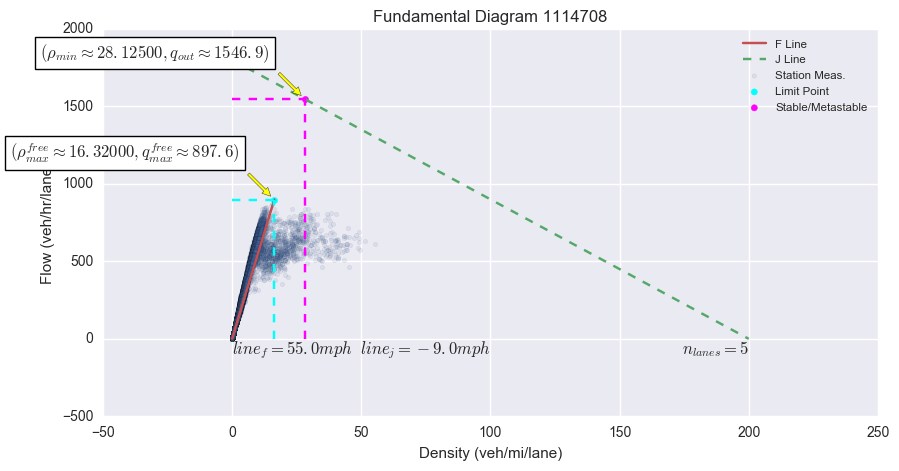

In [201]:
station = 1114708  # good 1114261, bad 1123134

latlon = meta_df.loc[station][['Latitude', 'Longitude']].tolist()
print 'Station {}, {}, \n{} \n{}'.format(station, latlon,
                                   meta_df.loc[station].Name,
                                  'https://www.google.com/maps/place/{},{}'.format(latlon[0], latlon[1]))

plt_fund_diag( df[df.Station==station], 
              'Fundamental Diagram {}'.format(station))

### <p style='color:blue'>Example good station: 1108723</p>

Station 1108723, [33.064771999999998, -117.292309], 
Leucadia Blvd 
https://www.google.com/maps/place/33.064772,-117.292309


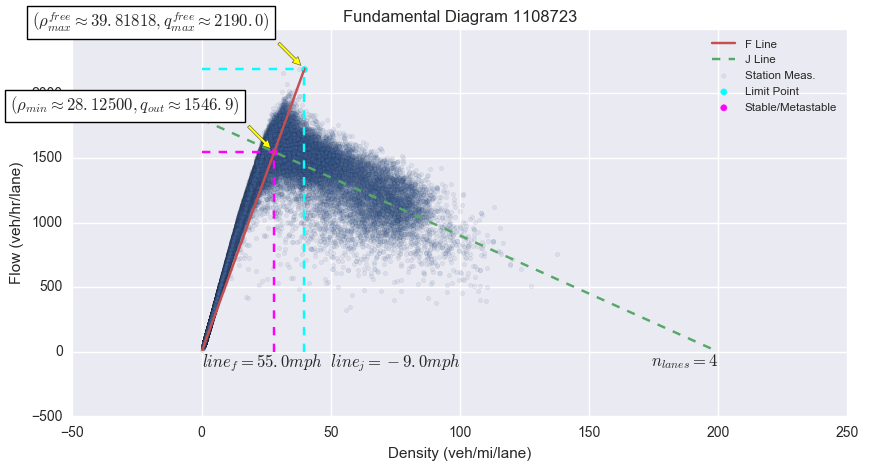

In [235]:
station = 1108723

latlon = meta_df.loc[station][['Latitude', 'Longitude']].tolist()
print 'Station {}, {}, \n{} \n{}'.format(station, latlon,
                                   meta_df.loc[station].Name,
                                  'https://www.google.com/maps/place/{},{}'.format(latlon[0], latlon[1]))

plt_fund_diag( df[df.Station==station], 
              'Fundamental Diagram {}'.format(station) )

### Multi-lane plot

Station 1108723, [33.064771999999998, -117.292309], 
Leucadia Blvd 
https://www.google.com/maps/place/33.064772,-117.292309


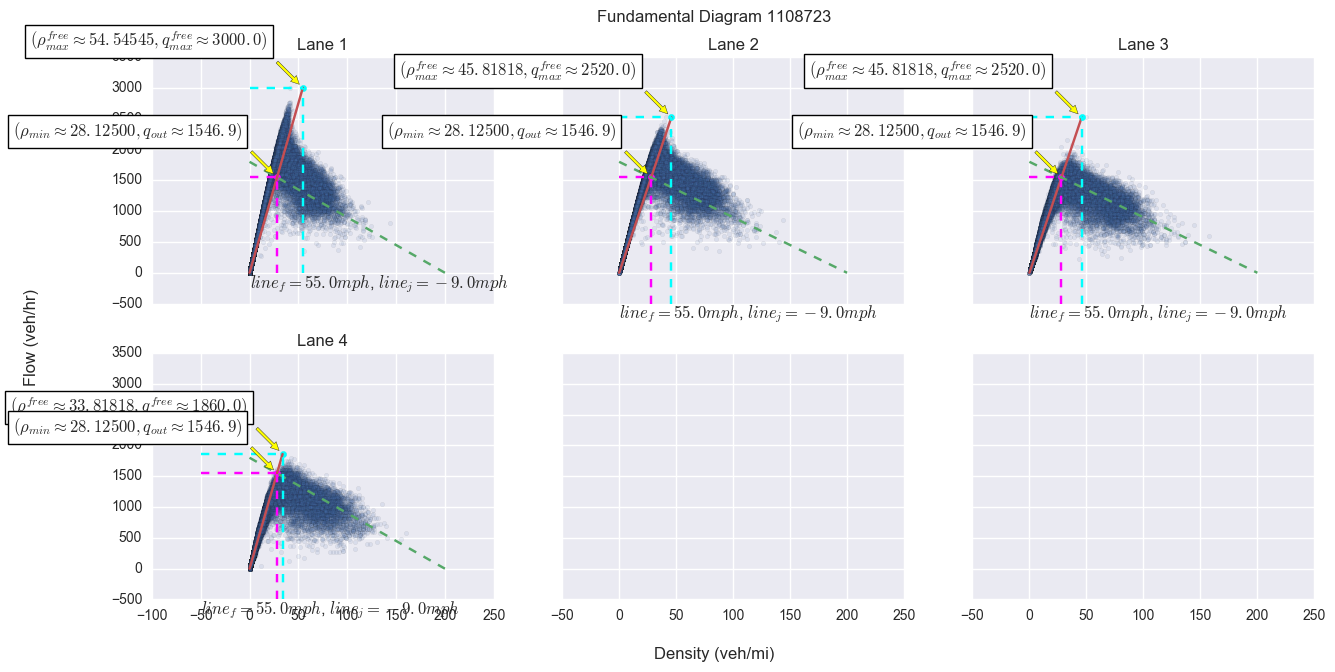

In [237]:
station = 1108723  # good: 1108723, bad: 1114708

latlon = meta_df.loc[station][['Latitude', 'Longitude']].tolist()
print 'Station {}, {}, \n{} \n{}'.format(station, latlon,
                                   meta_df.loc[station].Name,
                                  'https://www.google.com/maps/place/{},{}'.format(latlon[0], latlon[1]))

plt_lanes_fund_diag( df[df.Station==station], 
              'Fundamental Diagram {}'.format(station) )

### Single lane detail plot

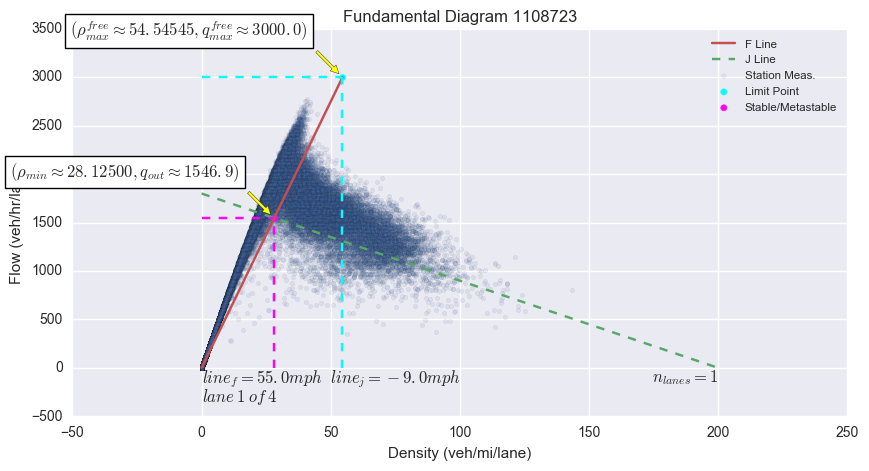

In [239]:
plt_fund_diag( df[df.Station==station], 
              'Fundamental Diagram {}'.format(station), lane=1 )

# All stations

In [ ]:
# Get ordered station list (I-5 southbound)
stations = meta_df.loc[df.Station.unique()].sort_values('Abs_PM', ascending=False).index.tolist()

SPLIT = 0.1

for station in stations:
    latlon = ['',''] if station not in meta_df.index.tolist() \
        else meta_df.loc[station][['Latitude', 'Longitude']].tolist()
    name = '' if station not in meta_df.index.tolist() else meta_df.loc[station].Name
    print 'Station {}, {}, \n{} \n{}'.format(station, latlon, name,
                'https://www.google.com/maps/place/{},{}'.format(latlon[0], latlon[1]))
    
    sub_df, _ = train_test_split( df[df.Station==station], train_size=SPLIT, random_state=15 )
    plt_fund_diag( sub_df, 'Fundamental Diagram {}'.format(station) )

### Bokeh version (incomplete)

In [67]:
def bk_fund_diag( df, title, to_file=None ):
    flow = df['TotalFlow'] * 12   #convert to cars/hr
    x, y = flow/df['AvgSpeed'], flow
    
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    
    idx = df[ df.TotalFlow==(ymax/12) ].index[0]
    
    q_max = ymax
    q_min = ymin
    p_max = x.loc[idx]
    q_out = q_max/1.5
    p_min = p_max/1.5
    
    def line_f( p ):
        f = lambda x: x*(q_max/p_max)
        if type(p)==type([]):
            return map(f, p)
        return f(p)
    
    fx = [xmin, p_max]
    fy = line_f( fx )
    
    jx = [p_min, xmax]
    jy = [q_out, q_min]
    
    fig = bkplot.figure(tools='pan, wheel_zoom, box_zoom, box_select, reset, save')
    fig.scatter( x, y, size=3, color='#3A5785', alpha=0.25 )
    fig.line( fx, fy, color='red' )
    fig.line( jx, jy, color='green' )
    fig.xaxis.axis_label = 'Density (veh/mi)'
    fig.yaxis.axis_label = 'Flow (veh/hr)'
    bkplot.show( fig )

In [ ]:
bk_fund_diag( sub_df, 'Test' )